# Horse vs Human

* **Reference**: http://www.laurencemoroney.com/horses-or-humans-dataset/

## Abstract

* Horses or Humans is a dataset of 300×300 images, created by Laurence Moroney, that is licensed CC-By-2.0 for anybody to use in learning or testing computer vision algorithms.

## Aim/Purpose:

* Data exploration of images
    - Summarise number of training/test cases.
* Neural Network building:
    - Data Augmentation:
        - Increase accuracy of **validation sets**
        - Rescaling/Normalize the images.
        - Rotation by angle.
        - Random shifting with range.
        - Shearing.
        - Random zooming.
        - Horizontal/Vertical Flipping.
    - Neural Network:
        - Apply **transfer learning** from https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5, including pretained weights for human an d horse.
        - Add a single **Flatten Layer** to convert matrix of pixels into array to further parsing.
        - Add a **Dropout** layer to probabilistically remove the inputs to a layer, which may be input variables in the data sample or activations from a previous layer.
        - Add **dense** layer to compile the weights and finally another one to determines the class of object.
])

* Loss function in Compiling:
    - Mainly we use Cross Entropy function as **log-loss function**.
    - For 2 class/binary classification:
        - Binary Crossentropy with Sigmoid Function.
    - For multi class classification:
        - Categorical Crossentropy
        - Sparse Categorical Crossentropy
        
* Optimizer in Compiling:
    - **Simple Reference**: https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a
    -  **RMSProp**: 
        - RMS stands for root mean square.
        - Keep the moving average of the squared gradients for each weight. 
        - And then we divide the gradient by square root the mean square.
        
## Summary of results:

* Successfully trained a neural network model with 98% and 100% accuracy on training and validation set respectively, within 3 epoch.
* High accuracy is verified by huge pre-tained model, and probably few number of validation sets.


In [161]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd
import numpy as np
from keras.preprocessing import image
from PIL import Image


In [2]:
#Load the Pretained Model from 
# https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

path_inception = f"{getcwd()}\\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
# Check Last Layer output shape.
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [4]:
# Define a Callback class that stops training once accuracy reaches 98%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True

In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)               
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)         

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
# Get the Horse or Human dataset
#path_horse_or_human = f"{getcwd()}/../tmp2/horse-or-human.zip"
# Get the Horse or Human Validation dataset
#path_validation_horse_or_human = f"{getcwd()}/../tmp2/validation-horse-or-human.zip"
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import os
#import zipfile
#import shutil

#shutil.rmtree('/tmp')
#local_zip = path_horse_or_human
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('/tmp/training')
#zip_ref.close()

#local_zip = path_validation_horse_or_human
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('/tmp/validation')
#zip_ref.close()

In [7]:
# Define our example directories and files
train_dir = f"{getcwd()}\\horse-or-human\\train"
validation_dir = f"{getcwd()}\\horse-or-human\\validation"
train_horses_dir = os.path.join(train_dir, 'horses') 
train_humans_dir = os.path.join(train_dir, 'humans') 
validation_horses_dir = os.path.join(validation_dir, 'horses') 
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [8]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))   

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [9]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 98% accuracy

callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 10,
            validation_steps = 25,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/10
50/50 - 186s - loss: 0.2796 - accuracy: 0.8926 - val_loss: 0.0178 - val_accuracy: 0.9879
Epoch 2/10
50/50 - 184s - loss: 0.1421 - accuracy: 0.9453 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 3/10
50/50 - 176s - loss: 0.0674 - accuracy: 0.9777 - val_loss: 2.4155e-04 - val_accuracy: 1.0000
Epoch 4/10

Reached 98% accuracy so cancelling training!
50/50 - 174s - loss: 0.0453 - accuracy: 0.9868 - val_loss: 4.3456e-04 - val_accuracy: 1.0000


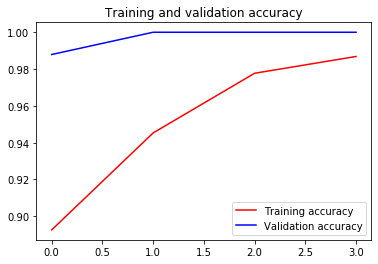

<Figure size 432x288 with 0 Axes>

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [169]:
import numpy as np
from keras.preprocessing import image
from PIL import Image

def horse_or_human(sample_image_name):
    img = image.load_img(f"{getcwd()}\\" + sample_image_name, target_size=(150, 150))
    x = image.img_to_array(img)/255.0
    x = np.expand_dims(x, axis=0)
    classes = model.predict(x, batch_size=10)
    if classes < 0.5:
        print("It's a horse!")
    elif classes >= 0.5:
        print("It's a human!")

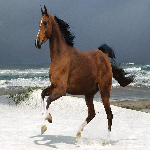

In [183]:
from keras.preprocessing import image
img = image.load_img(f"{getcwd()}\\" + "random_horse.jpg", target_size=(150, 150))
img

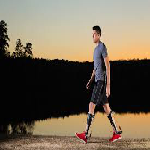

In [185]:
from keras.preprocessing import image
img = image.load_img(f"{getcwd()}\\" + "random_human.jpg", target_size=(150, 150))
img

In [187]:
import numpy as np
from keras.preprocessing import image
from PIL import Image

horse_or_human("random_horse.jpg")
horse_or_human("random_human.jpg")

It's a horse!
It's a human!
